#### A bit of cluster ananlysis: choosing the optimal number of clusters

In [6]:
import json
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [37]:
with open('boardgames_100.json') as f:
    data = json.load(f)

with open('../cat.json') as f:
    cats = json.load(f)


In [8]:
# get the fans-also-like relationships using Yagmur's code
fans_also_like = {}
for game in data:
    game_id = game['id']
    fans = game['recommendations']['fans_liked']
    fans_also_like[game_id] = fans

# Erstelle die Ähnlichkeitsmatrix basierend auf den Fans-also-Like-Beziehungen
n = len(data)
similarity_matrix = np.zeros((n, n))
for i, game in enumerate(data):
    game_id = game['id']
    fans = fans_also_like[game_id]
    for fan in fans:
        fan_idx = next((idx for idx, g in enumerate(data) if g['id'] == fan), None)
        if fan_idx is not None:
            similarity_matrix[i, fan_idx] = len(fans) #statt 0 oder 1 zuweisen in Matrix betrachten wir die Anzahl der gemeinsamen Fans

In [9]:
# TODO: try a gaussian distribution

std = np.std([g['id'] for g in data])

similarity_matrix_gaussian = np.zeros((n, n))
for i, game in enumerate(data):
    game_id = game['id']
    fans = fans_also_like[game_id]
    # generate a cumulative distribution function by summing up individual gaussians
    # An individual gaussian is centered at the fan's position and has a standard deviation of 1
    mu = np.sum(fans) / len(fans)
    
    for j, g in enumerate(data):
        similarity_matrix_gaussian[i, j] = np.exp(-((g['id'] - mu)**2) / std**2)
        

Visualize the data in 2D using t-SNE (not really necessary at this point, but can be used as a reference when we plot the clusters)

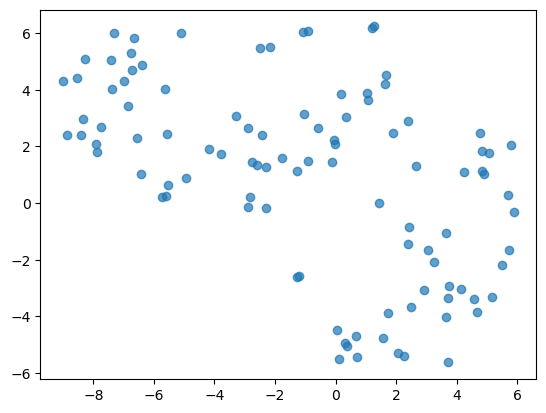

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE()

tsne_rep = tsne.fit_transform(similarity_matrix)
plt.scatter(tsne_rep[:, 0], tsne_rep[:, 1], alpha=0.7)

Choose the optimal number of clusters based on the following metrics:

1) The distortion score (the sum of squared distances from each point to its assigned center)

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

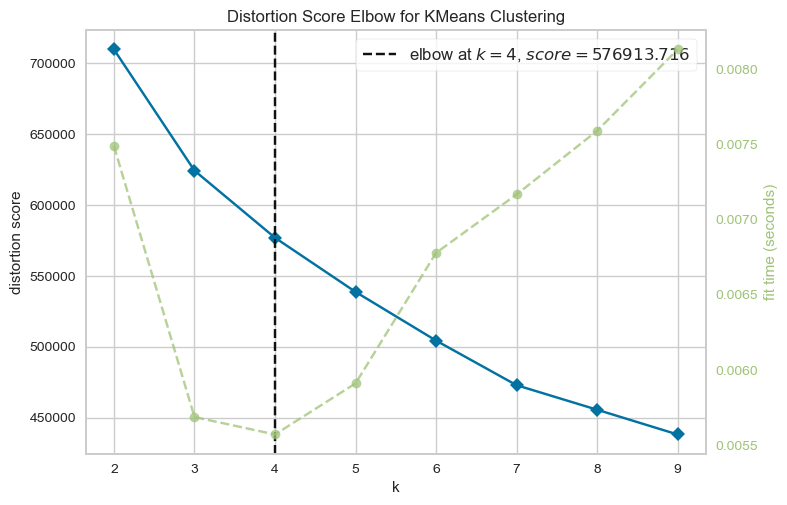

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [11]:
# get the optimal number of clusters using the elbow method
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

model = KMeans()

# 1. the dsitortion curve
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(similarity_matrix)       
visualizer.poof()

2) The Calinski-Harabasz score (the ratio of the sum of between-clusters dispersion and of within-cluster dispersion)

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

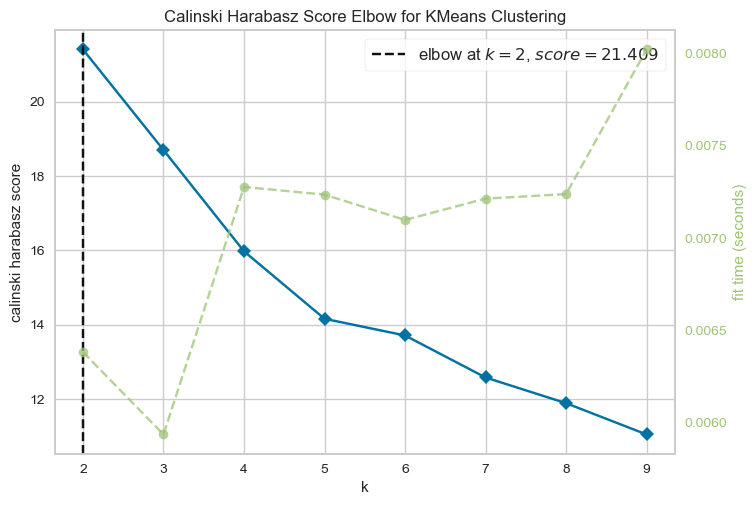

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [12]:
# 2. the CH-index curve

visualizer = KElbowVisualizer(model, k=(2, 10), metric='calinski_harabasz')
visualizer.fit(similarity_matrix)
visualizer.poof()

From the above graphs, one can see that there are two choices for the optimal number of clusters: 2 and 4.

To decide further, we look at the silhoutte scores obtained for each num_clusters.

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


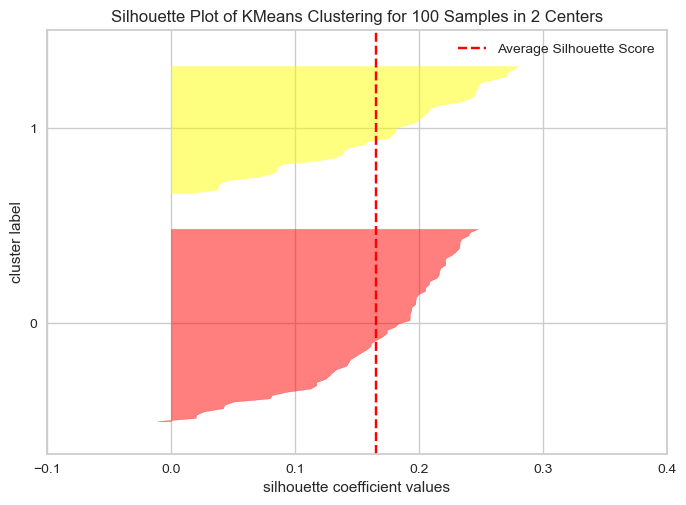

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 100 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
# plot the silhouette score to choose between the num_clusters as 4 or 2

from yellowbrick.cluster import SilhouetteVisualizer

model = KMeans(2)
visualizer = SilhouetteVisualizer(model, colors='autumn')

visualizer.fit(similarity_matrix)
visualizer.show()


/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


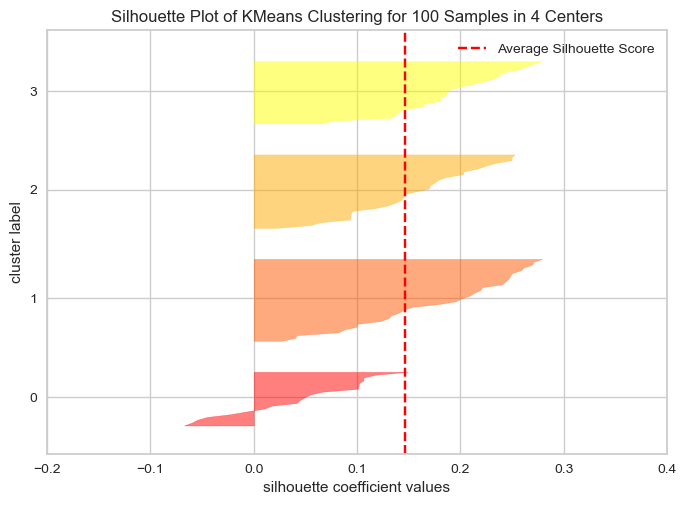

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 100 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [14]:
model = KMeans(4)
visualizer = SilhouetteVisualizer(model, colors='autumn')

visualizer.fit(similarity_matrix)
visualizer.show()

the silhouette score is higher for 2 clusters

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


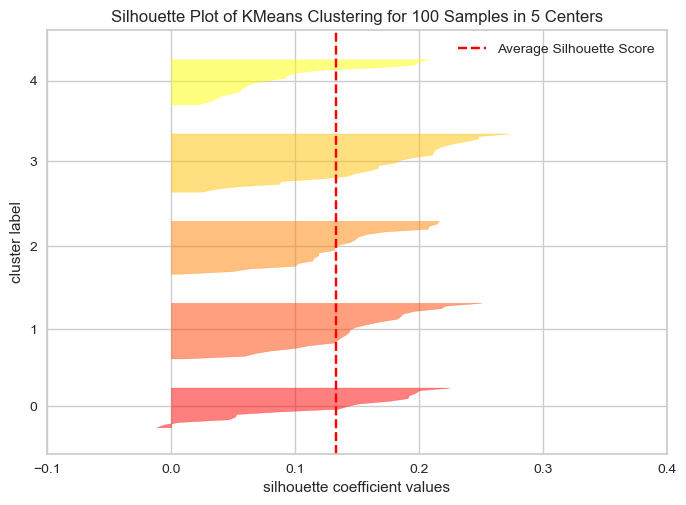

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 100 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [15]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model, colors='autumn')

visualizer.fit(similarity_matrix)
visualizer.show()

this looks better, the silhoutte score is almost the same

As the silhoutte scores for num_clusters=2, 4, and 5 are nearly the same,  we can choose a higher number of clusters to get more separation.

We apply Kmeans using different num_clusters and compare the results

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


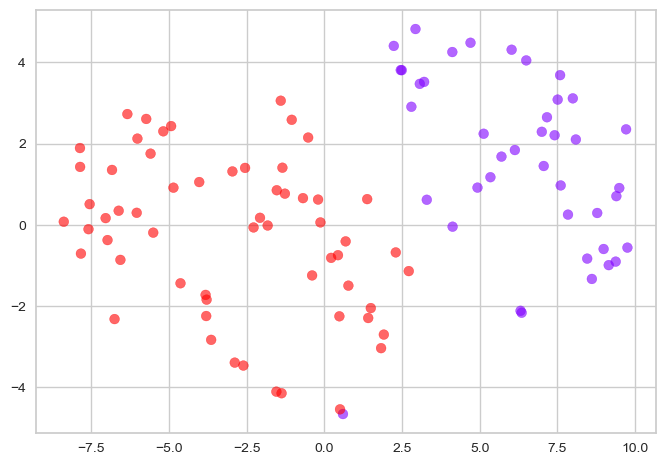

In [16]:
km = KMeans(n_clusters=2, init='random')
y_km = km.fit_predict(similarity_matrix)

cluster_centers = km.cluster_centers_
cluster_labels = km.labels_

# plot the clusters on t-SNE

cluster_tsne = TSNE().fit_transform(similarity_matrix)
plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1], c=y_km, s=50, cmap='rainbow', alpha=0.6)


for num_clusters=5

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


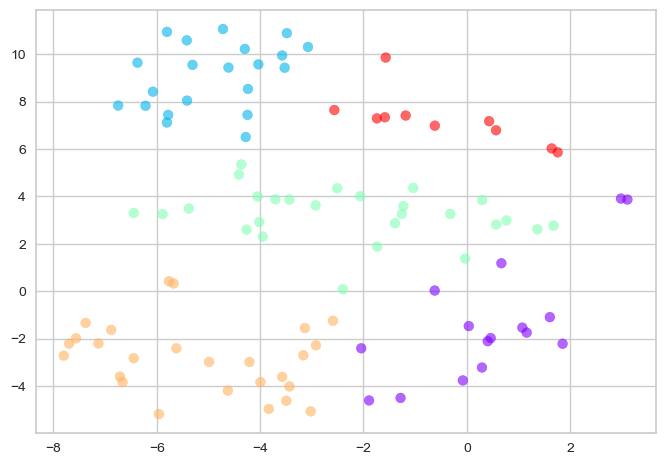

In [17]:
km = KMeans(n_clusters=5, init='random')
y_km = km.fit_predict(similarity_matrix)

cluster_centers = km.cluster_centers_
cluster_labels = km.labels_

# plot the clusters on t-SNE

cluster_tsne = TSNE().fit_transform(similarity_matrix)
plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1],
            c=y_km, s=50, cmap='rainbow', alpha=0.6)


finally, for num_clusters=4

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


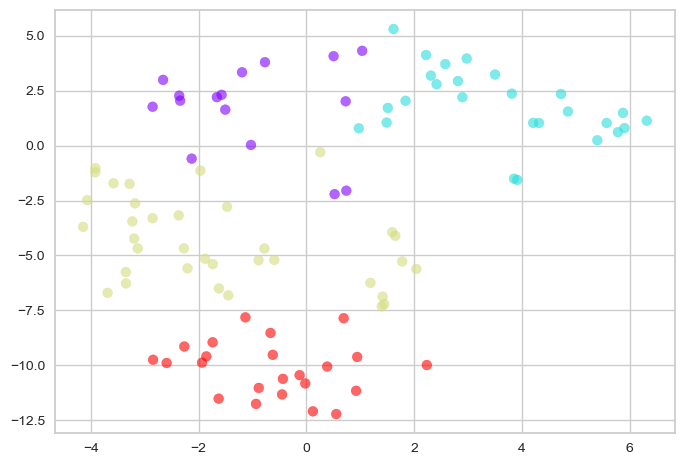

In [18]:
km = KMeans(n_clusters=4, init='random')
y_km = km.fit_predict(similarity_matrix)

cluster_centers = km.cluster_centers_
cluster_labels = km.labels_

# plot the clusters on t-SNE

cluster_tsne = TSNE().fit_transform(similarity_matrix)
plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1],
            c=y_km, s=50, cmap='rainbow', alpha=0.6)

the seperation obtained using 4 or 5 clusters is more along the lines of our idea of how the final graph should look like ?

-------------------

For the gaussian matrix

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

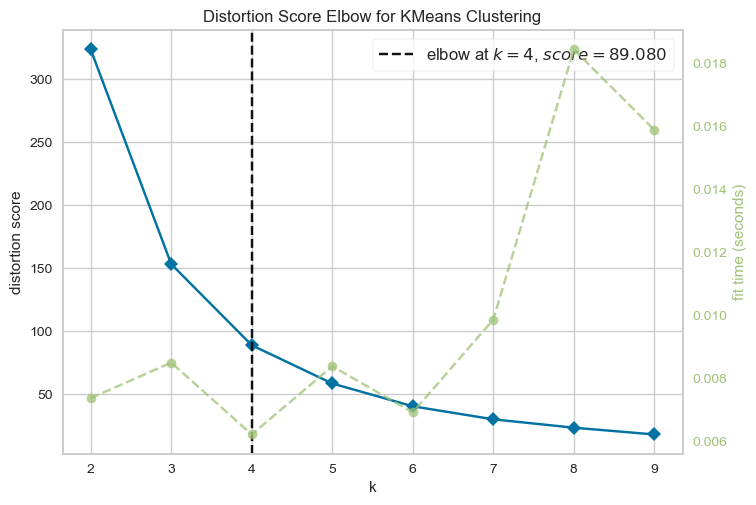

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
model = KMeans()

# 1. the dsitortion curve
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(similarity_matrix_gaussian)
visualizer.poof()


/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

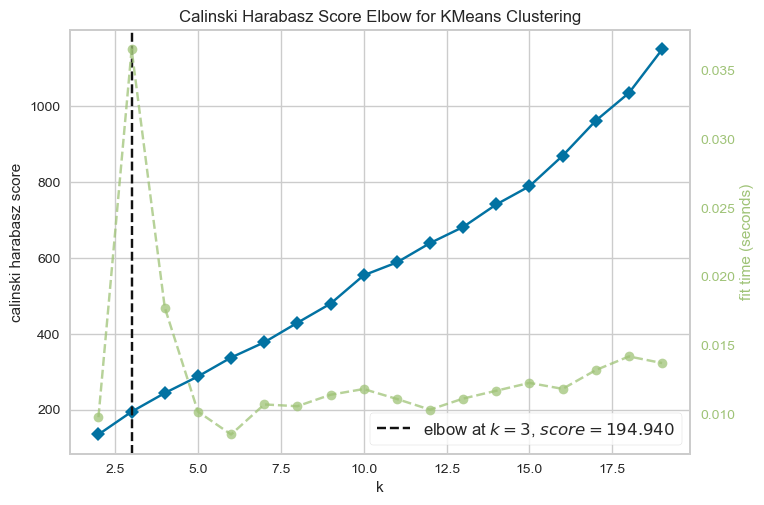

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [20]:
model = KMeans()

# 1. the dsitortion curve
visualizer = KElbowVisualizer(model, k=(2, 20), metric='calinski_harabasz')
visualizer.fit(similarity_matrix_gaussian)       
visualizer.poof()

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


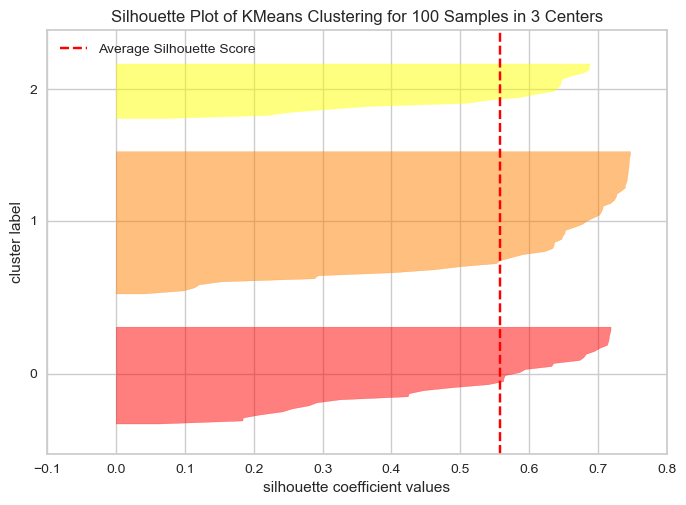

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 100 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
model = KMeans(3)
visualizer = SilhouetteVisualizer(model, colors='autumn')

visualizer.fit(similarity_matrix_gaussian)
visualizer.show()

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


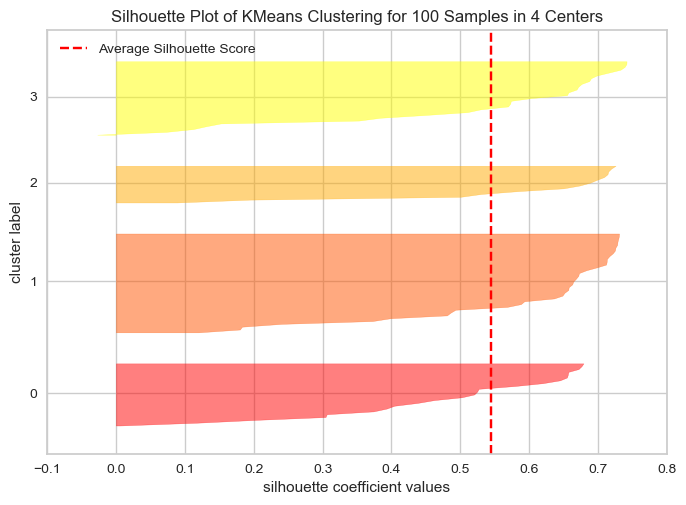

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 100 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
model = KMeans(4)
visualizer = SilhouetteVisualizer(model, colors='autumn')

visualizer.fit(similarity_matrix_gaussian)
visualizer.show()


The silhoutte scores are also higher if we use a gaussian matrix instead of the original matrix

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


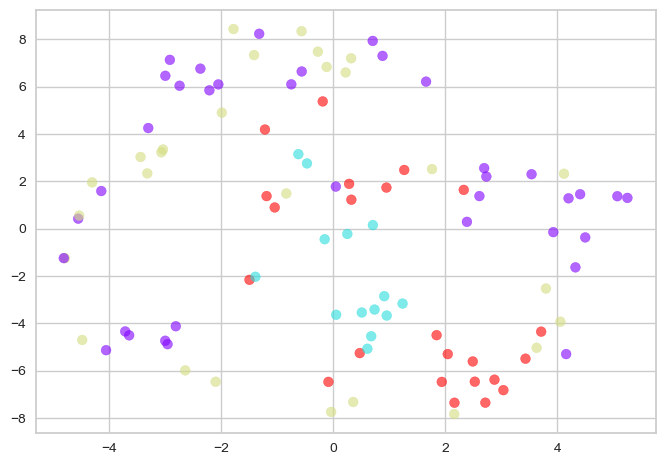

In [23]:
km = KMeans(n_clusters=4, init='random')
y_km = km.fit_predict(similarity_matrix_gaussian)

cluster_centers = km.cluster_centers_
cluster_labels = km.labels_

# plot the clusters on t-SNE

cluster_tsne = TSNE().fit_transform(similarity_matrix)
plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1], c=y_km, s=50, cmap='rainbow', alpha=0.6)

but the clusters do not look separable, atleast in 2D

In [26]:
import networkx as nx
import networkx.algorithms as nxalg

game_id2idx = {game['id']: i for i, game in enumerate(data)}

G = nx.DiGraph()
for game in data:
    G.add_node(game["id"])
    for liked in game["recommendations"]["fans_liked"]:
        G.add_edge(game["id"], liked)


edge_centrality = nxalg.edge_betweenness_centrality(G, normalized=True)

similarity_edge_betweenness_centrality = np.zeros((n, n))

for i, game in enumerate(data):
    for liked in game["recommendations"]["fans_liked"]:
        if liked not in game_id2idx:
            continue
        j = game_id2idx[liked]
        similarity_edge_betweenness_centrality[i, j] = edge_centrality[(game["id"], liked)]

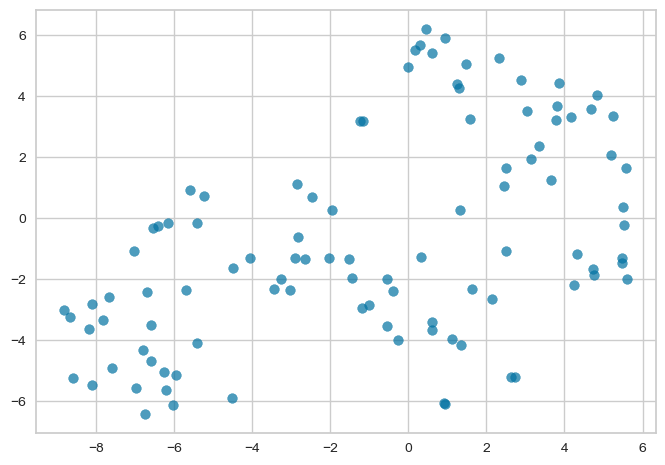

In [27]:
from sklearn.manifold import TSNE
tsne = TSNE()

tsne_rep = tsne.fit_transform(similarity_matrix)
plt.scatter(tsne_rep[:, 0], tsne_rep[:, 1], alpha=0.7)

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

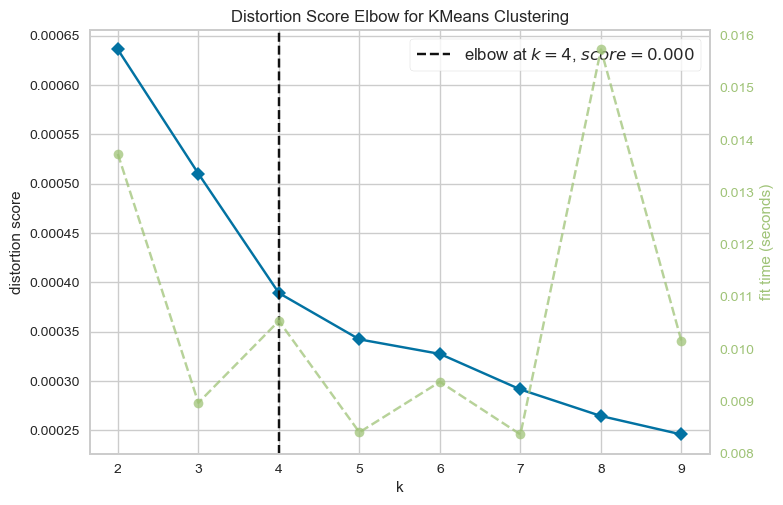

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
# get the optimal number of clusters using the elbow method
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

model = KMeans()

# 1. the dsitortion curve
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(similarity_edge_betweenness_centrality)       
visualizer.poof()

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


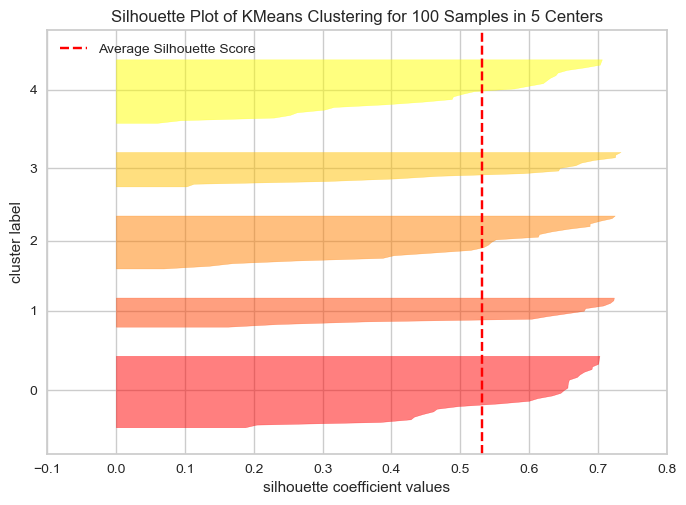

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 100 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [29]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model, colors='autumn')

visualizer.fit(similarity_edge_betweenness_centrality)
visualizer.show()

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


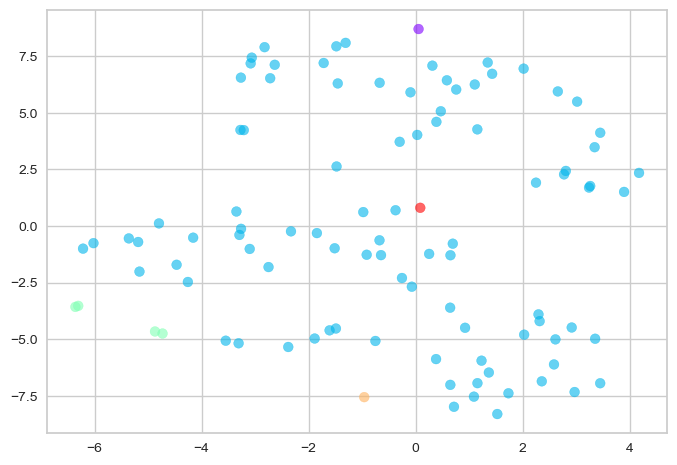

In [33]:
km = KMeans(n_clusters=5, init='random')
y_km = km.fit_predict(similarity_edge_betweenness_centrality)

cluster_centers = km.cluster_centers_
cluster_labels = km.labels_

# plot the clusters on t-SNE

cluster_tsne = TSNE().fit_transform(similarity_matrix)
plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1], c=y_km, s=50, cmap='rainbow', alpha=0.6)

In [40]:

cat_similarity_matrix = np.zeros((n, n))

def calc_cat_vec(cat):
    a = np.array(
        list(
            map(
                lambda item: item["votes"],
                sorted(cat["poll_results"], key=lambda x: x["category"]["id"]),
            )
        )
    )
    return a / np.linalg.norm(a)


for i, (game, cat) in enumerate(zip(data, cats)):
    if "cat_v" not in cat:
        cat["cat_v"] = calc_cat_vec(cat)

    for liked in game["recommendations"]["fans_liked"]:
        if liked not in game_id2idx:
            continue
        j = game_id2idx[liked]
        if "cat_v" not in cats[j]:
            cats[j]["cat_v"] = calc_cat_vec(cats[j])
        cat_similarity_matrix[i, j] = np.dot(cat["cat_v"], cats[j]["cat_v"])
    

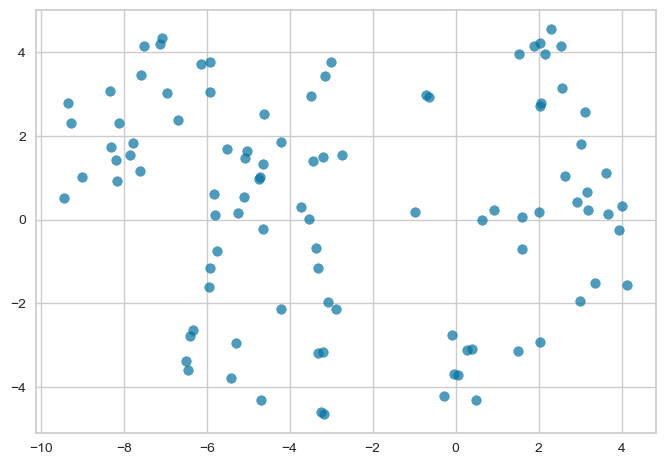

In [42]:
from sklearn.manifold import TSNE
tsne = TSNE()

tsne_rep = tsne.fit_transform(cat_similarity_matrix)
plt.scatter(tsne_rep[:, 0], tsne_rep[:, 1], alpha=0.7)

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

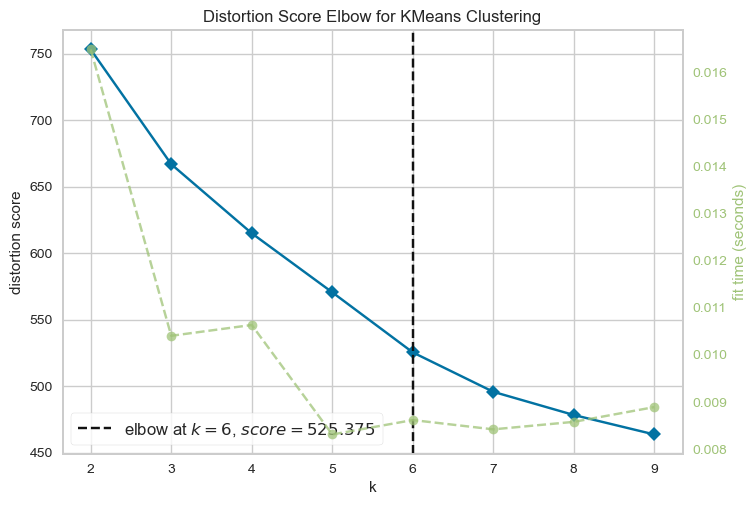

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
model = KMeans()

# 1. the dsitortion curve
visualizer = KElbowVisualizer(model, k=(2, 10))
visualizer.fit(cat_similarity_matrix)       
visualizer.poof()

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


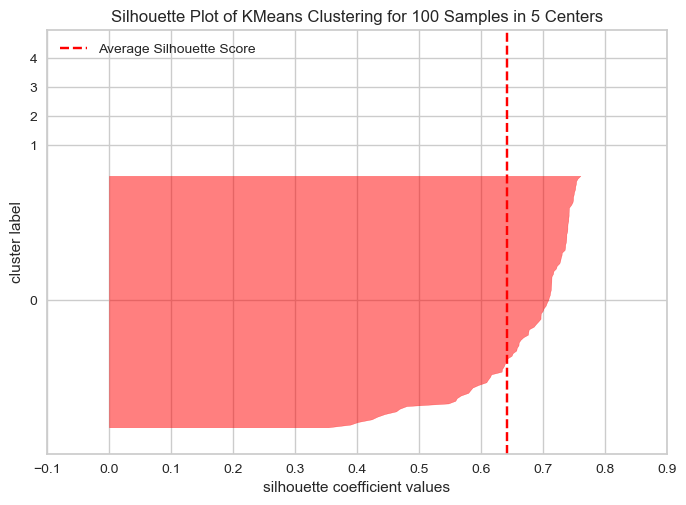

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 100 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [49]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model, colors='autumn')

visualizer.fit(similarity_edge_betweenness_centrality)
visualizer.show()

/Users/david/.local/share/mamba/envs/graph/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


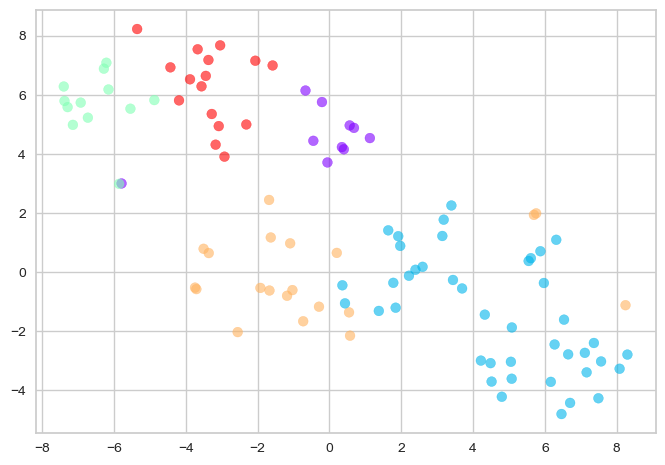

In [48]:
km = KMeans(n_clusters=5, init='random')
y_km = km.fit_predict(cat_similarity_matrix)

cluster_centers = km.cluster_centers_
cluster_labels = km.labels_

# plot the clusters on t-SNE

cluster_tsne = TSNE().fit_transform(similarity_matrix)
plt.scatter(cluster_tsne[:, 0], cluster_tsne[:, 1], c=y_km, s=50, cmap='rainbow', alpha=0.6)